In [1]:
from __future__ import annotations
from copy import deepcopy
import numpy as np
import networkx as nx       
import matplotlib.pyplot as plt
import pandas as pd
import functools
import random
import time
import random
from typing import List
from dataclasses import dataclass
from pygame_visualization import VRPVisualizator

pygame 2.0.1 (SDL 2.0.14, Python 3.9.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
GRAPH_SIZE = 80
X_MIN = -600
X_MAX = 600
Y_MIN = -400
Y_MAX = 400
MIN_DISTANCE_BETWEEN_POINTS = 50
VIZU_SCALING = 1.3
K_TRUCKS = 3
K_MEANS_SLEEP = 0

NUMBER_RUN_ACO = 20

NBR_ANTS = 15
NBR_GENERATION = 20

In [3]:
vizu = VRPVisualizator()
vizu.set_scaling(VIZU_SCALING)

In [4]:
def manhattan(a, b):
    return sum(abs(val1-val2) for val1, val2 in zip(a,b))

In [5]:
random.seed(42)
def generate_coordinates(n_nodes: int, x_coords_range, y_coords_range, min_distance: float):
    generated_coords = [(0, 0)]
    vizu.add_node(0, 0)
    for i in range(n_nodes - 1):
        is_ok = False
        while not is_ok:
            coord = (random.uniform(*x_coords_range), random.uniform(*y_coords_range))
            is_ok = True
            for node in generated_coords:
                if manhattan(coord, node) < min_distance:
                    is_ok = False
        generated_coords.append(coord)
        vizu.add_node(coord[0], coord[1])
    return generated_coords

In [6]:
points = generate_coordinates(GRAPH_SIZE, (X_MIN, X_MAX), (Y_MIN, Y_MAX), MIN_DISTANCE_BETWEEN_POINTS)
random.seed()

# K-means clustering

## 1- k-means++ centroids selection

In [7]:
def select_initial_centroids(points: list, k: int, display) -> list:
    vizu.clear_centroids_and_color()
    #Initialize list of centroids with a first random chosen one.
    first_centroid = list(random.choice(points))
    vizu.add_centroid(first_centroid)
    centroids = [first_centroid]
    for i_centroid in range(k - 1):
        print('GENERATED:', i_centroid)
        #Store minimum distances of each points to a centroid.
        all_distances = []
        for i_point, point in enumerate(points):
            min_distance = float('inf')
            best_i_centroid = 0
            #Compute the lowest distance to a previously selected
            #centroid from this point.
            for i_centroid in range(len(centroids)):
                distance = manhattan(point, centroids[i_centroid])
                if distance < min_distance:
                    min_distance = distance
                    best_i_centroid = i_centroid

            vizu.bind_to_centroid(i_point, best_i_centroid)
            if display:
                vizu.add_centroid_line(point, centroids[best_i_centroid])
                time.sleep(K_MEANS_SLEEP)
            all_distances.append(min_distance)
        
        #Select the point with maximum distance as our new centroid
        next_centroid = list(points[np.argmax(np.array(all_distances))])
        centroids.append(next_centroid)
        vizu.add_centroid(next_centroid)
        vizu.clear_centroid_lines()
    return centroids

In [8]:
@dataclass
class SubPoint():
    global_index: int
    coordinates: tuple

def calc_centroid(points):
    points = np.array(points)
    length = points.shape[0]
    sum_x = np.sum(points[:, 0])
    sum_y = np.sum(points[:, 1])
    return [sum_x/length, sum_y/length]

def generate_clusters(points, centroids, display) -> List[List[SubPoint]]:
    centroids_childs = dict()
    centroid_changed = True

    while centroid_changed:
        for i in range(len(centroids)):
            centroids_childs[i] = []

        for i_point, point in enumerate(points):
            #Get the closest centroid
            min_distance = float('inf')
            best_i_centroid = 0
            for i_centroid in range(len(centroids)):
                distance = manhattan(point, centroids[i_centroid])
                if distance < min_distance:
                    best_i_centroid = i_centroid
                    min_distance = distance

            #Create subpoint to keep track of the global index of the node
            #Global index is i+1 because i = 0 = depot
            subpoint = SubPoint(i_point + 1, point)
            centroids_childs[best_i_centroid].append(subpoint)
            vizu.bind_to_centroid(i_point, best_i_centroid)
            if display:
                vizu.add_centroid_line(point, centroids[best_i_centroid])
                time.sleep(K_MEANS_SLEEP)

        if display:
            vizu.clear_centroid_lines()
        centroid_changed = False
        #Update centroids values
        for i_centroid, centroid in enumerate(centroids):
            childs_coordinates = [subpoint.coordinates for subpoint in centroids_childs[i_centroid]]
            new_centroid_value = calc_centroid(childs_coordinates)
            if new_centroid_value != centroid:
                centroid_changed = True
                centroid[0] = new_centroid_value[0]
                centroid[1] = new_centroid_value[1]
    vizu.clear_centroids()
    clusters = [centroids_childs[centroid] for centroid in centroids_childs.keys()]
    return clusters

In [9]:
def generate_distance_matrix(points: list):
    length = len(points)
    matrix = np.empty((length, length))
    matrix[:] = np.nan
    for i in range(length):
        for j in range(length):
            if i != j:
                dist = manhattan(points[i], points[j])
                matrix[i][j] = dist
                matrix[j][i] = dist
    return matrix

def generate_graphs_from_clusters(clusters):
    graphs = []
    for cluster in clusters:
        #Start by adding the depot point
        points_coordinates = [points[0]]
        points_indexes = [0]
        for subpoint in cluster:
            points_coordinates.append(subpoint.coordinates)
            points_indexes.append(subpoint.global_index)
        distance_matrix = generate_distance_matrix(points_coordinates)
        graphs.append((points_indexes, distance_matrix))
    return graphs

In [10]:
points_without_0 = list(points)
points_without_0.pop(0)
centroids = select_initial_centroids(points_without_0, K_TRUCKS, True)
clusters = generate_clusters(points_without_0, centroids, True)
graphs = generate_graphs_from_clusters(clusters)
vizu.draw()

GENERATED: 0
GENERATED: 1


In [11]:
#Evaporation factor for global update of pheromones
RHO = 0.2
#Evaporation factor for local update of pheromones
KAPPA = RHO
#Q
OMICRON = 1
#Impact of pheromones
ALPHA = 1
#Impact of weights
BETA = 1.5
#Initial pheromones
TAU = 1
#Exploration/exploitation trade off
EPSILON = 0.6

In [12]:
class Ant():
    def __init__(self, real_nodes_indexes, init_pos: int, vizualizator: VRPVisualizator) -> None:
        self.real_nodes_indexes = real_nodes_indexes
        self.init_pos = init_pos
        self.vizualizator = vizualizator
        self.current_pos = init_pos
        self.path_history = [init_pos]
        self.can_continue = True

    def add_to_path_history(self, node) -> None:
        self.path_history.append(node)
        if self.vizualizator:
            self.vizualizator.set_path(self.get_real_path(self.path_history))

    def move(self, dest: list, pheromones: list) -> None:
        choice = random.uniform(0, 1)

        if choice <= EPSILON:
            dest_picked = self.exploitation(dest, pheromones[self.current_pos])
        else:
            dest_picked = self.biased_exploration(dest, pheromones[self.current_pos])

        if dest_picked is None:
            self.add_to_path_history(self.init_pos)
            self.can_continue = False
            return

        self.update_pheromones_locally(pheromones, dest_picked)
        self.current_pos = dest_picked
        self.add_to_path_history(self.current_pos)

    def exploitation(self, dest: list, pheromones: list) -> int:
        current_best_viability = None
        current_best_dest = None
        for i in range(len(dest)):
            if not np.isnan(dest[i]) and i not in self.path_history:
                viability = pheromones[i] * (KAPPA / dest[i])**BETA
                if not current_best_viability or viability > current_best_viability:
                    current_best_viability = viability
                    current_best_dest = i
        return current_best_dest

    def biased_exploration(self, dest: list, pheromones: list) -> int:
        probabilities = []
        denominator = 0
        
        #Calculate the denominator first
        for i in range(len(dest)):
            if not np.isnan(dest[i]):
                denominator += pheromones[i]**ALPHA * (KAPPA/dest[i])**BETA

        #Calculate probabilities of picking one path
        for node, length in enumerate(dest):
            if node in self.path_history:
                probabilities.append(0)
            elif not np.isnan(dest[node]):
                nominator = pheromones[node]**ALPHA * (KAPPA/dest[node])**BETA
                probabilities.append(nominator / denominator)
            else:
                probabilities.append(np.nan)
        
        #If there is no path available return false
        if np.nansum(probabilities) == 0:
            return None

        #Roulette wheel
        cumulative_sum = []
        for i in range(len(probabilities)):
            if np.isnan(probabilities[i]):
                cumulative_sum.append(np.nan)
            elif np.nansum(cumulative_sum) == 0:
                cumulative_sum.append(1.0)
            else:
                cumulative_sum.append(np.nansum(probabilities[i:len(probabilities)]))
        
        #Pick a destination
        rand = random.uniform(0, 1)
        dest_picked = None
        cumulative_sum.append(0)

        for i in range(0, len(cumulative_sum)-1):
            p = cumulative_sum[i]
            nextp = cumulative_sum[i+1] if not np.isnan(cumulative_sum[i+1]) else cumulative_sum[i+2] if not np.isnan(cumulative_sum[i+2]) else cumulative_sum[i+3]
        
            if not np.isnan(p) and rand <= p and rand >= nextp:
                dest_picked = i
        return dest_picked

    def update_pheromones_locally(self, pheromones: list, dest: int) -> None:
        #Apply the ACS local updating rule
        pheromones[self.current_pos][dest] = (1-RHO) * pheromones[self.current_pos][dest] + RHO * TAU
        #pheromones[dest][self.current_pos] = (1-RHO) * pheromones[dest][self.current_pos] + RHO * TAU
    
    def get_real_node_index(self, index):
        return self.real_nodes_indexes[index]

    def get_real_path(self, path):
        real_path = []
        for n in path:
            real_path.append(self.get_real_node_index(n))
        return real_path

In [13]:
class ACO():
    def __init__(self, graph, real_nodes_indexes, start: int, vizualizator: VRPVisualizator = None) -> None:
        self.graph = graph
        self.real_nodes_indexes = real_nodes_indexes
        self.start = start
        self.vizualizator = vizualizator
        self.current_best_path = None
        self.current_best_length =  float('inf')
        algo_neighbOURS = ALGO_neightbours(graph, 0)
        length, path = algo_neighbOURS.run()
        TAU = (length*30)**-1
        self.pheromones = np.full(graph.shape, TAU)

    def run(self, iter: int) -> list:
        for i in range(iter):
            print('Tour:', i)
            self.tour_construction(NBR_ANTS)
            self.global_update_pheromones()
        real_best_path = self.get_real_path(self.current_best_path)
        if self.vizualizator:
            self.vizualizator.add_path(real_best_path)
            self.vizualizator.clear_current_path()
        print('Best:', real_best_path)
        print('Length:', self.current_best_length)
        return real_best_path, self.current_best_length

    def tour_construction(self, ant_amount: int) -> None:
        ants = [Ant(self.real_nodes_indexes, random.randint(0, len(self.real_nodes_indexes)-1), self.vizualizator) for i in range(ant_amount)]
        while ants:
            for ant in ants:
                if ant.can_continue:
                    ant.move(self.graph[ant.current_pos], self.pheromones)
                else:
                    self.update_current_best(ant.path_history)
                    ants.remove(ant)

    def update_current_best(self, path):
        path_length = self.calc_total_distance(path)
        if path_length < self.current_best_length:
            print('NEW BEST:', path)
            print('BEST LENGTH:', path_length)
            self.current_best_path = path
            self.current_best_length = path_length

    def global_update_pheromones(self) -> None:
        #Evaporation
        self.pheromones *= 1 - RHO
        #New pheromones
        for i in range(len(self.current_best_path)-1):
            current_node = self.current_best_path[i]
            next_node = self.current_best_path[i+1]
            self.pheromones[current_node][next_node] += RHO * (KAPPA / self.current_best_length)
            #self.pheromones[next_node][current_node] += RHO * (KAPPA / self.current_best_length)

    def calc_total_distance(self, full_path: list) -> float:
        distance = 0
        for i in range(len(full_path)-1):
            cur_path = full_path[i]
            next_path = full_path[i+1]
            distance += self.graph[cur_path][next_path]
        return distance
    
    def get_real_node_index(self, index):
        return self.real_nodes_indexes[index]

    def get_real_path(self, path):
        real_path = []
        for n in path:
            real_path.append(self.get_real_node_index(n))
        return real_path

In [14]:
class ALGO_neightbours():
    def __init__(self, graph, start: int) -> None:
        self.graph = deepcopy(graph)
        self.start = start
        self.best_length = 0
        self.current_node = 0
        self.path_history = [0]

    def run(self) -> list:   
        while len(self.path_history) < (len(self.graph)):
            actual_graph = self.graph[self.current_node]
            for i in self.path_history:
                actual_graph[i] = float("inf")
            min_distance = np.nanmin(actual_graph)
            next_node = np.where(actual_graph == min_distance)[0][0]
            self.path_history.append(next_node)
            self.current_node = next_node
            self.best_length += min_distance
        
        self.path_history.append(0)
        self.best_length += self.graph[self.current_node][0]
        return self.best_length,self.path_history   

In [15]:
total_distance_ACO = []
for i in range(1):
    vizu.clear_paths()
    result_paths = []
    result_distances = []
    start = time.time()
    for graph in graphs:
        aco = ACO(graph[1], graph[0], 0)
        path, distance = aco.run(NBR_GENERATION)
        vizu.add_path(path)
        result_paths.append(path)
        result_distances.append(distance)
    total_distance_ACO.append(sum(result_distances))
    print('TOTAL DISTANCE : ', sum(result_distances))
    print('TOTAL TIME : ', time.strftime('%H:%M:%S', time.gmtime(time.time()-start)))


Tour: 0
NEW BEST: [2, 21, 27, 25, 10, 5, 19, 12, 24, 23, 1, 13, 0, 17, 14, 7, 22, 8, 4, 18, 9, 0, 3, 26, 20, 16, 15, 11, 6, 2]
BEST LENGTH: 5184.6389378948725
Tour: 1
NEW BEST: [11, 26, 20, 16, 15, 18, 9, 22, 8, 4, 6, 0, 17, 14, 2, 21, 27, 25, 10, 5, 19, 12, 24, 23, 1, 13, 7, 3, 11]
BEST LENGTH: 4160.584471440194
Tour: 2
Tour: 3
Tour: 4
Tour: 5
Tour: 6
Tour: 7
Tour: 8
Tour: 9
Tour: 10
Tour: 11
Tour: 12
Tour: 13
Tour: 14
Tour: 15
Tour: 16
Tour: 17
Tour: 18
Tour: 19
Best: [27, 78, 56, 45, 41, 51, 21, 64, 20, 7, 14, 0, 47, 36, 5, 61, 79, 76, 23, 12, 54, 31, 70, 66, 2, 32, 19, 6, 27]
Length: 4160.584471440194
Tour: 0
NEW BEST: [11, 4, 21, 17, 23, 19, 22, 13, 6, 8, 26, 15, 0, 10, 20, 1, 24, 25, 3, 28, 7, 27, 29, 14, 16, 12, 18, 2, 9, 5, 11]
BEST LENGTH: 6413.050781788814
Tour: 1
NEW BEST: [1, 24, 25, 3, 28, 7, 27, 29, 14, 0, 4, 11, 2, 6, 8, 26, 15, 12, 16, 21, 17, 23, 19, 22, 13, 18, 10, 20, 9, 5, 1]
BEST LENGTH: 6136.1254939064875
Tour: 2
Tour: 3
NEW BEST: [16, 12, 18, 19, 22, 13, 6, 2, 0,

In [16]:
print('TOTAL DISTANCE:', sum(result_distances))
print('PATHS:', result_paths)

TOTAL DISTANCE: 13444.917214116289
PATHS: [[27, 78, 56, 45, 41, 51, 21, 64, 20, 7, 14, 0, 47, 36, 5, 61, 79, 76, 23, 12, 54, 31, 70, 66, 2, 32, 19, 6, 27], [22, 49, 1, 18, 10, 68, 4, 75, 13, 73, 58, 0, 40, 35, 71, 15, 11, 3, 50, 8, 25, 55, 48, 53, 30, 42, 28, 38, 34, 77, 22], [24, 33, 67, 0, 59, 63, 74, 17, 65, 44, 69, 9, 39, 26, 57, 43, 52, 60, 72, 62, 29, 37, 16, 46, 24]]


In [17]:
vizu.clear_paths()
for path in result_paths:
    vizu.add_path(path)

In [18]:
STAT_INDEX = ["ALPHA","BETA","EPSILON","Nbr Ants","Nbr Generations","Iterations","Avg Time","min","max","avg","Length Graph"]
STAT_ITERATION = 1
INDEX_BEST_VALUE = 7
INDEX_AVG_VALUE = 9
def start_multiple_ACO(alpha : float,beta : float,epsilon : float,nbr_ants : int,nbr_generation : int,iteration : int):
    ETA = beta
    ALPHA = alpha
    EPSILON = epsilon
    NBR_ANTS = nbr_ants
    NBR_GENERATION = nbr_generation
    total_distance_ACO = []
    times = []
    for i in range(iteration):
        vizu.clear_paths()
        result_paths = []
        result_distances = []
        start = time.time()
        for graph in graphs:
            aco = ACO(graph[1], graph[0], 0)
            path, distance = aco.run(NBR_GENERATION)
            vizu.add_path(path)
            result_paths.append(path)
            result_distances.append(distance)
        total_distance_ACO.append(sum(result_distances))
        times.append(time.time()-start)
        print('TOTAL DISTANCE : ', sum(result_distances))
        print('TOTAL TIME : ', time.strftime('%H:%M:%S', time.gmtime(time.time()-start)))
    avg_time = sum(times)/len(times)
    return transform_values_to_stat(total_distance_ACO,alpha,beta,epsilon,nbr_ants,nbr_generation,iteration,time.strftime('%H:%M:%S', time.gmtime(time.time()-start)))

def transform_values_to_stat(datas:List,alpha : float,beta : float,epsilon : float,nbr_ants : int,nbr_generation : int,iteration : int,avg_time : str):
    values = []
    values.append(alpha)
    values.append(beta)
    values.append(epsilon)
    values.append(nbr_ants)
    values.append(nbr_generation)
    values.append(iteration)
    values.append(avg_time)
    values.append(min(datas))
    values.append(max(datas))
    values.append(sum(datas)/len(datas))
    values.append(GRAPH_SIZE)
    return values

def formate_data_to_dataframe(original_data):
    formated_value = []
    for i in range(len(original_data[0])):
        temp_data = []
        for a in range(len(original_data)):
            temp_data.append(original_data[a][i])
        formated_value.append(temp_data)
    return formated_value
start_multiple_ACO(0.9,2,0.7,30,40,1)

Tour: 0
NEW BEST: [15, 26, 3, 23, 5, 24, 0, 14, 17, 21, 27, 25, 0, 10, 13, 1, 7, 11, 20, 16, 9, 8, 22, 4, 12, 6, 0, 2, 19, 18, 15]
BEST LENGTH: 6632.1703400926945
Tour: 1
NEW BEST: [2, 19, 12, 6, 8, 22, 9, 15, 18, 4, 0, 14, 17, 21, 27, 25, 10, 5, 24, 23, 0, 3, 26, 11, 20, 16, 7, 0, 13, 1, 2]
BEST LENGTH: 5938.016254060779
Tour: 2
NEW BEST: [16, 15, 18, 4, 8, 22, 9, 0, 14, 17, 21, 27, 25, 10, 5, 19, 12, 24, 23, 1, 7, 13, 11, 20, 6, 26, 3, 2, 16]
BEST LENGTH: 5371.476570117753
NEW BEST: [23, 1, 7, 11, 20, 16, 15, 6, 8, 22, 9, 0, 14, 17, 21, 27, 25, 10, 5, 19, 12, 24, 13, 26, 3, 18, 4, 2, 23]
BEST LENGTH: 5168.615333907259
Tour: 3
NEW BEST: [4, 8, 22, 9, 16, 15, 18, 6, 24, 23, 1, 7, 11, 0, 14, 17, 21, 27, 25, 10, 5, 19, 12, 2, 13, 26, 3, 20, 4]
BEST LENGTH: 4450.609338646315
Tour: 4
Tour: 5
Tour: 6
Tour: 7
Tour: 8
Tour: 9
Tour: 10
Tour: 11
Tour: 12
Tour: 13
Tour: 14
Tour: 15
Tour: 16
Tour: 17
Tour: 18
Tour: 19
Tour: 20
Tour: 21
Tour: 22
Tour: 23
Tour: 24
Tour: 25
Tour: 26
Tour: 27
Tour: 2

[0.9,
 2,
 0.7,
 30,
 40,
 1,
 '00:00:24',
 12545.55087738821,
 12545.55087738821,
 12545.55087738821,
 80]

In [19]:
data_ACO = [start_multiple_ACO(1,1.5,0.6,15,20,STAT_ITERATION)]
data_ACO.append(start_multiple_ACO(1,2,0.6,15,20,STAT_ITERATION))
data_ACO.append(start_multiple_ACO(1,1.5,0.8,15,20,STAT_ITERATION))
#data_ACO.append(start_multiple_ACO(1,2,0.8,15,20,STAT_ITERATION))
#data_ACO.append(start_multiple_ACO(1,2,0.6,30,20,STAT_ITERATION))
#data_ACO.append(start_multiple_ACO(1,2,0.6,15,40,STAT_ITERATION))
#data_ACO.append(start_multiple_ACO(1,2,0.6,30,40,STAT_ITERATION))

pd.DataFrame(formate_data_to_dataframe(data_ACO),index=STAT_INDEX)

Tour: 0
NEW BEST: [2, 21, 17, 14, 0, 4, 8, 22, 9, 15, 16, 20, 26, 11, 0, 25, 27, 10, 5, 19, 13, 1, 23, 7, 24, 12, 6, 18, 3, 2]
BEST LENGTH: 5521.6960278275055
Tour: 1
NEW BEST: [6, 12, 24, 23, 1, 0, 25, 27, 10, 5, 19, 2, 0, 3, 26, 11, 7, 13, 21, 17, 14, 22, 9, 15, 16, 20, 18, 4, 8, 6]
BEST LENGTH: 4929.211964278405
Tour: 2
Tour: 3
NEW BEST: [10, 5, 19, 12, 24, 23, 1, 0, 16, 20, 15, 18, 4, 8, 22, 9, 6, 13, 7, 11, 26, 3, 0, 25, 27, 21, 17, 14, 2, 10]
BEST LENGTH: 4744.261606582662
Tour: 4
NEW BEST: [25, 27, 21, 17, 14, 0, 3, 26, 11, 7, 23, 1, 13, 10, 5, 19, 12, 24, 6, 8, 22, 9, 15, 16, 20, 18, 4, 2, 25]
BEST LENGTH: 3992.7670859687328
Tour: 5
Tour: 6
Tour: 7
Tour: 8
Tour: 9
Tour: 10
Tour: 11
Tour: 12
Tour: 13
Tour: 14
Tour: 15
NEW BEST: [16, 20, 15, 18, 4, 8, 22, 9, 6, 12, 24, 7, 23, 1, 13, 10, 5, 19, 2, 21, 17, 14, 27, 25, 0, 3, 26, 11, 16]
BEST LENGTH: 3445.0356003276047
Tour: 16
Tour: 17
Tour: 18
Tour: 19
Best: [45, 56, 41, 51, 7, 20, 64, 21, 14, 31, 70, 19, 66, 2, 32, 23, 12, 54, 5, 

,0,1,2
ALPHA,1,1,1
BETA,1.5,2,1.5
EPSILON,0.6,0.6,0.8
Nbr Ants,15,15,15
Nbr Generations,20,20,20
Iterations,1,1,1
Avg Time,00:00:12,00:00:12,00:00:12
min,12232.886315,12844.535612,13466.309746
max,12232.886315,12844.535612,13466.309746
avg,12232.886315,12844.535612,13466.309746


In [20]:
STAT_ITERATION = 2

total_distance_neightbours = 0
for graph in graphs:
    algo_neightbours = ALGO_neightbours(graph[1], 0)
    distance_neightbours,path_neightbours = algo_neightbours.run()
    total_distance_neightbours += distance_neightbours
print("Total distance neightbour algo",total_distance_neightbours)

all_values = [total_distance_neightbours]
best_current_values = [total_distance_neightbours]

total_distance_ACO = []
for i in range(STAT_ITERATION):
    total_distance_ACO.append(start_multiple_ACO(1,2,0.7,30,40,STAT_ITERATION)[INDEX_AVG_VALUE])


for i in total_distance_ACO:
    if i < best_current_values[-1]:
        best_current_values.append(i)
    else:
        best_current_values.append(best_current[-1])
    all_values.append(i)

plt.xlabel("Nb iterations", fontsize=16)
plt.ylabel("Value", fontsize=16)
res = plt.plot(range(STAT_ITERATION+1), all_values)
res = plt.plot(range(STAT_ITERATION+1), best_current_values)


Total distance neightbour algo 12260.361386668406
Tour: 0
NEW BEST: [15, 8, 22, 9, 16, 20, 0, 25, 13, 1, 23, 24, 12, 19, 5, 10, 21, 27, 17, 14, 2, 7, 11, 0, 3, 26, 18, 6, 4, 15]
BEST LENGTH: 5297.736269585163
Tour: 1
NEW BEST: [18, 6, 4, 8, 22, 9, 16, 20, 0, 17, 14, 10, 21, 27, 0, 25, 0, 3, 26, 11, 15, 7, 23, 1, 13, 5, 19, 2, 12, 24, 18]
BEST LENGTH: 5175.675135258178
Tour: 2
NEW BEST: [6, 4, 0, 25, 27, 21, 10, 5, 19, 2, 17, 14, 13, 1, 23, 24, 12, 7, 26, 11, 16, 20, 15, 8, 22, 9, 18, 3, 6]
BEST LENGTH: 4803.546162408561
Tour: 3
NEW BEST: [27, 25, 13, 1, 23, 7, 24, 12, 19, 2, 21, 10, 5, 0, 3, 26, 11, 16, 20, 15, 18, 6, 4, 8, 22, 9, 17, 14, 27]
BEST LENGTH: 4171.0368637118645
Tour: 4
Tour: 5
Tour: 6
Tour: 7
Tour: 8
Tour: 9
Tour: 10
Tour: 11
Tour: 12
Tour: 13
Tour: 14
Tour: 15
Tour: 16
Tour: 17
Tour: 18
Tour: 19
Tour: 20
Tour: 21
Tour: 22
Tour: 23
Tour: 24
Tour: 25
Tour: 26
Tour: 27
Tour: 28
Tour: 29
Tour: 30
Tour: 31
Tour: 32
Tour: 33
Tour: 34
Tour: 35
Tour: 36
Tour: 37
Tour: 38
Tour: 39

NameError: name 'best_current' is not defined

In [ ]:
print(graph)
plt.xlabel("Nbr", fontsize=16)
plt.ylabel("Min Value", fontsize=16)
res = plt.plot(range(len(clean_data_ACO[7])), clean_data_ACO[INDEX_AVG_VALUE])

In [79]:
STAT_NBR_ITERATION = 1

data_ACO_alpha = []
data_ACO_epsilon = []
data_ACO_beta = []

alpha_index = [2,1.5,1.2,1,0.8,0.6,0.4,0.2]
beta_index = [2,1.5,1.2,1,0.8,0.6,0.4,0.2] 
epsilon_index = [0.9,0.8,0.6,0.4] 

for i in alpha_index:
    data_ACO_alpha.append(start_multiple_ACO(i,2,0.6,30,40,STAT_NBR_ITERATION))

print("FINISH ALPHA")

for i in beta_index:
    data_ACO_beta.append(start_multiple_ACO(1,i,0.6,30,40,STAT_NBR_ITERATION))

print("FINISH BETA")

for i in epsilon_index:
    data_ACO_epsilon.append(start_multiple_ACO(1,2,i,30,40,STAT_NBR_ITERATION))

print("FINISH EPSILON")


plt.xlabel("Value Parameter", fontsize=16)
plt.ylabel("Min Value", fontsize=16)
print(clean_data_ACO_alpha)
res = plt.plot(alpha_index, formate_data_to_dataframe(data_ACO_alpha)[INDEX_AVG_VALUE],'r',label="alpha")
res = plt.plot(beta_index, formate_data_to_dataframe(data_ACO_beta)[INDEX_AVG_VALUE],'g',label="beta")
res = plt.plot(epsilon_index, formate_data_to_dataframe(data_ACO_epsilon)[INDEX_AVG_VALUE],'b',label="epsilon")
plt.legend()

<ipython-input-68-8710334c38ec>:58: RuntimeWarning: invalid value encountered in double_scalars
  probabilities.append(nominator / denominator)
TOTAL DISTANCE :  inf
TOTAL TIME :  00:00:28


KeyboardInterrupt: 

[[2, 1.5, 1.2, 1, 0.8, 0.6, 0.4, 0.2], [2, 2, 2, 2, 2, 2, 2, 2], [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6], [30, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 40, 40, 40, 40], [2, 2, 2, 2, 2, 2, 2, 2], ['00:00:04', '00:00:04', '00:00:04', '00:00:04', '00:00:04', '00:00:04', '00:00:04', '00:00:04'], [10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157], [10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157], [10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157, 10314.042645464157], [50, 50, 50, 50, 50, 50, 50, 50]]


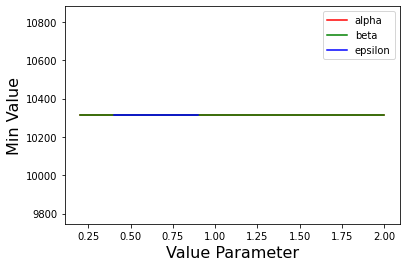

In [30]:
start_multiple_ACO((1,2,0.6,30,40,STAT_NBR_ITERATION))

In [129]:
pd.DataFrame(clean_data_ACO_alpha,index=STAT_INDEX)

,0,1,2,3
ALPHA,1,1,1,1
BETA,2,2,2,2
EPSILON,0.9,0.8,0.6,0.4
Nbr Ants,30,30,30,30
Nbr Generations,40,40,40,40
Iterations,1,1,1,1
Avg Time,00:00:05,00:00:05,00:00:05,00:00:05
min,10169.222159,10199.225718,10217.242718,10167.884836
max,10169.222159,10199.225718,10217.242718,10167.884836
avg,10169.222159,10199.225718,10217.242718,10167.884836


In [130]:
pd.DataFrame(clean_data_ACO_beta,index=STAT_INDEX)

,0,1,2,3,4,5,6,7
ALPHA,1,1,1,1,1,1,1,1
BETA,2,1.5,1.2,1,0.8,0.6,0.4,0.2
EPSILON,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
Nbr Ants,30,30,30,30,30,30,30,30
Nbr Generations,40,40,40,40,40,40,40,40
Iterations,1,1,1,1,1,1,1,1
Avg Time,00:00:05,00:00:05,00:00:05,00:00:05,00:00:05,00:00:05,00:00:05,00:00:05
min,10257.950049,10297.865628,10263.238857,10307.916549,10189.066771,10167.884836,10173.512387,10157.144109
max,10257.950049,10297.865628,10263.238857,10307.916549,10189.066771,10167.884836,10173.512387,10157.144109
avg,10257.950049,10297.865628,10263.238857,10307.916549,10189.066771,10167.884836,10173.512387,10157.144109


In [131]:
pd.DataFrame(clean_data_ACO_epsilon,index=STAT_INDEX)

,0,1,2,3
ALPHA,1,1,1,1
BETA,2,2,2,2
EPSILON,0.9,0.8,0.6,0.4
Nbr Ants,30,30,30,30
Nbr Generations,40,40,40,40
Iterations,1,1,1,1
Avg Time,00:00:05,00:00:05,00:00:05,00:00:05
min,10169.222159,10199.225718,10217.242718,10167.884836
max,10169.222159,10199.225718,10217.242718,10167.884836
avg,10169.222159,10199.225718,10217.242718,10167.884836


In [134]:
data_ACO_alpha = []
data_ACO_alpha.append(start_multiple_ACO(0.30,0.30,0.6,30,40,5))
clean_data_ACO_alpha = []
for i in range(len(data_ACO_alpha[0])):
    temp_data_ACO_alpha = []
    for a in range(len(data_ACO_alpha)):
        temp_data_ACO_alpha.append(data_ACO_alpha[a][i])
    clean_data_ACO_alpha.append(temp_data_ACO_alpha)
pd.DataFrame(clean_data_ACO_alpha,index=STAT_INDEX)

<ipython-input-51-8710334c38ec>:58: RuntimeWarning: invalid value encountered in double_scalars
  probabilities.append(nominator / denominator)
TOTAL DISTANCE :  10836.376272844374
TOTAL TIME :  00:00:04
TOTAL DISTANCE :  10836.376272844374
TOTAL TIME :  00:00:04
TOTAL DISTANCE :  10836.376272844374
TOTAL TIME :  00:00:04
TOTAL DISTANCE :  10836.376272844374
TOTAL TIME :  00:00:04
TOTAL DISTANCE :  10836.376272844374
TOTAL TIME :  00:00:04


,0
ALPHA,0.3
BETA,0.3
EPSILON,0.6
Nbr Ants,30
Nbr Generations,40
Iterations,5
Avg Time,00:00:04
min,10836.376273
max,10836.376273
avg,10836.376273
